In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [2]:
import os
os.environ["TAVILY_API_KEY"] = "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"

In [9]:


memory = MemorySaver()

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]


groq_api = "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"

llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api)

llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]

def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END


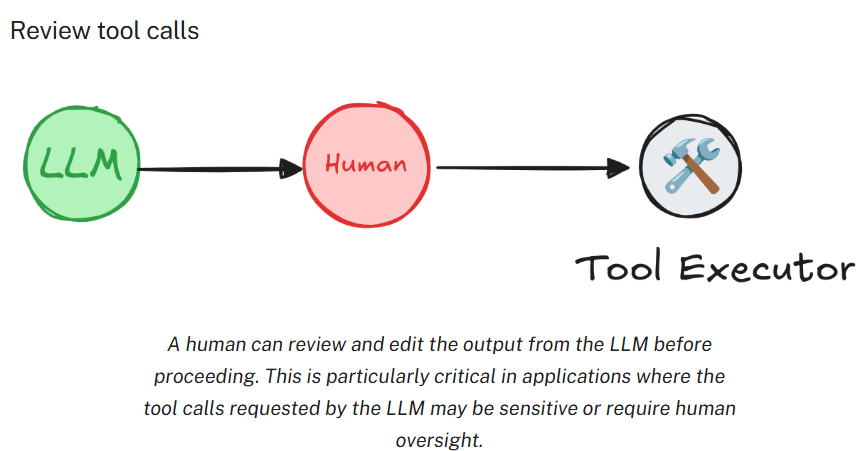

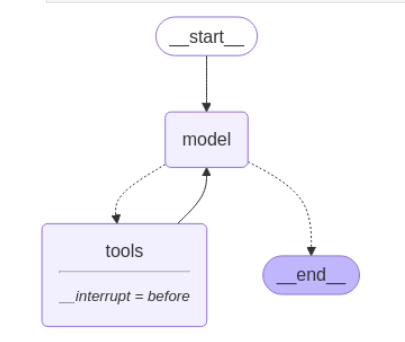

In [10]:

graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

In [15]:
# from IPython.display import Image, display

# display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
config = {"configurable": {
    "thread_id": 369
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Chennai?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c2a75g255)
 Call ID: c2a75g255
  Args:
    query: Current weather in Chennai today


In [13]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [14]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c2a75g255)
 Call ID: c2a75g255
  Args:
    query: Current weather in Chennai today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Chennai Weather Today (Friday, Jul 11, 2025) - India Today", "url": "https://www.indiatoday.in/weather/chennai-weather-forecast-today", "content": "The minimum temperature in Chennai today is likely to hover around 27 degrees Celsius, while the maximum temperature might reach 35 degrees Celsius. The mercury level is expected to hover around 35 degrees Celsius throughout the day, with the wind speed around 7.42. The wind will move around 208 degrees with a gust speed of 12.08. The sunrise time is 05:48 AM, while it will set at 06:39 PM on Friday. As per the seven-day weather prediction, the temperature in Chennai is likely to reach 35 [...] degrees Celsius on 